In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, coalesce 
from pyspark.sql.window import Window
import pyspark.pandas as pds


spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

sqlCtx = SQLContext(spark)

/Users/marco/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Load the dataset

In [2]:
df = spark.read.csv('BeerProject.csv', header = True, inferSchema = True, encoding = 'ISO-8859-1')
df.dtypes, df.count()

([('beer_ABV', 'double'),
  ('beer_beerId', 'int'),
  ('beer_brewerId', 'int'),
  ('beer_name', 'string'),
  ('beer_style', 'string'),
  ('review_appearance', 'double'),
  ('review_palette', 'double'),
  ('review_overall', 'double'),
  ('review_taste', 'double'),
  ('review_profileName', 'string'),
  ('review_aroma', 'double'),
  ('review_text', 'string'),
  ('review_time', 'string')],
 528870)

## Drop columns

Remove useless columns 

In [3]:
columns_to_drop = ['review_time', 'review_profileName']
df = df.drop(*columns_to_drop)
df.show(5)

+--------+-----------+-------------+--------------------+--------------------+-----------------+--------------+--------------+------------+------------+--------------------+
|beer_ABV|beer_beerId|beer_brewerId|           beer_name|          beer_style|review_appearance|review_palette|review_overall|review_taste|review_aroma|         review_text|
+--------+-----------+-------------+--------------------+--------------------+-----------------+--------------+--------------+------------+------------+--------------------+
|     5.0|      47986|        10325|        Sausa Weizen|          Hefeweizen|              2.5|           2.0|           1.5|         1.5|         1.5|A lot of foam. Bu...|
|     6.2|      48213|        10325|            Red Moon|  English Strong Ale|              3.0|           2.5|           3.0|         3.0|         3.0|Dark red color, l...|
|     6.5|      48215|        10325|Black Horse Black...|Foreign / Export ...|              3.0|           2.5|           3.0|    

## Handle missing values

Count missing values

In [4]:
for column in df.dtypes:
    print(column[0], df.filter(col(column[0]).isNull()).count())

beer_ABV 20280
beer_beerId 0
beer_brewerId 0
beer_name 0
beer_style 0
review_appearance 0
review_palette 0
review_overall 0
review_taste 0
review_aroma 0
review_text 119


### Remove review_text

Since the missing values for review_text are only 119 we dicided to remove them.

In [5]:
df = df.na.drop(subset = 'review_text')

print('Missing values in review_text: {}'.format(df.filter(col('review_text').isNull()).count()))

Missing values in review_text: 0


### Fill beer_ABV

In [6]:
df.createOrReplaceTempView("beer_schema")

Fill missing values taking the values from the beer with the avarege of the beer with the same name where 'beer_ABV' was not missing

In [7]:
query = """SELECT beer_name, Round(AVG(beer_ABV), 1) as beer_ABV
           FROM beer_schema  
           GROUP BY beer_name
           ORDER BY beer_ABV DESC"""

names = sqlCtx.sql(query)
names.show(10)
print('Unique Beer names: {}'.format(names.count()))

+--------------------+--------+
|           beer_name|beer_ABV|
+--------------------+--------+
|Schorschbräu Scho...|    57.7|
|Schorschbräu Scho...|    43.0|
|Schorschbräu Scho...|    39.4|
|Schorschbräu Scho...|    30.9|
|Samuel Adams Utopias|    27.0|
|Samuel Adams Utop...|    25.0|
|Samuel Adams Utop...|    25.0|
|Samuel Adams Utop...|    24.0|
|Samuel Adams Mill...|    21.0|
|Cuvée Alex Le Rou...|    19.5|
+--------------------+--------+
only showing top 10 rows

Unique Beer names: 18339


We fill in missing values for which there is a non-NULL match in the query result

In [8]:
df = df.join(names.select('beer_name', 'beer_ABV'), ['beer_name'], "left")\
                .withColumn('new_beer_ABV', coalesce(df.beer_ABV, names.beer_ABV))\
                .drop('beer_ABV').withColumnRenamed('new_beer_ABV', 'beer_ABV')

df.show(5)

+--------------------+-----------+-------------+--------------------+-----------------+--------------+--------------+------------+------------+--------------------+--------+
|           beer_name|beer_beerId|beer_brewerId|          beer_style|review_appearance|review_palette|review_overall|review_taste|review_aroma|         review_text|beer_ABV|
+--------------------+-----------+-------------+--------------------+-----------------+--------------+--------------+------------+------------+--------------------+--------+
|Black Horse Black...|      48215|        10325|Foreign / Export ...|              3.0|           2.5|           3.0|         3.0|         3.0|Almost totally bl...|     6.5|
| Caldera Ginger Beer|      52159|         1075|Herbed / Spiced Beer|              3.5|           3.5|           3.0|         3.0|         3.5|Poured from the b...|     4.7|
|            Red Moon|      48213|        10325|  English Strong Ale|              3.0|           2.5|           3.0|         3.0|

In [9]:
print('Remaining missing values: {}. We filled 2360 values.'.format(df.filter(col('beer_ABV').isNull()).count()))

Remaining missing values: 17918. We filled 2360 values.


Fill remaining missing values using the mean of the 'beer_style' for each style, and subsituting the NULL with the mean of the corresponding style

In [10]:
query = """SELECT beer_style, Round(AVG(beer_ABV), 1) as beer_ABV
           FROM beer_schema  
           GROUP BY beer_style
           ORDER BY beer_ABV DESC"""

style = sqlCtx.sql(query)
style.show(10)
print('Unique Beer styles: {}'.format(style.count()))

+--------------------+--------+
|          beer_style|beer_ABV|
+--------------------+--------+
|             Eisbock|    12.6|
|           Wheatwine|    11.6|
| American Strong Ale|    11.0|
|    Quadrupel (Quad)|    10.9|
|  English Barleywine|    10.7|
| American Barleywine|    10.3|
|             Braggot|    10.3|
|Bière de Champagn...|    10.2|
|American Double /...|    10.1|
|             Old Ale|     9.7|
+--------------------+--------+
only showing top 10 rows

Unique Beer styles: 104


In [11]:
df=df.join(style.select('beer_style', 'beer_ABV'), ['beer_style'], "left")\
                .withColumn('new_beer_ABV', coalesce(df.beer_ABV, style.beer_ABV))\
                .drop('beer_ABV').withColumnRenamed('new_beer_ABV', 'beer_ABV')

#system the columns in the original position
df = df.select(['beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name', 'beer_style','review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'review_overall', 'review_text'])

df.show(5)

+--------+-----------+-------------+--------------------+--------------------+-----------------+--------------+------------+------------+--------------+--------------------+
|beer_ABV|beer_beerId|beer_brewerId|           beer_name|          beer_style|review_appearance|review_palette|review_taste|review_aroma|review_overall|         review_text|
+--------+-----------+-------------+--------------------+--------------------+-----------------+--------------+------------+------------+--------------+--------------------+
|     6.5|      48215|        10325|Black Horse Black...|Foreign / Export ...|              3.0|           2.5|         3.0|         3.0|           3.0|Almost totally bl...|
|     4.7|      52159|         1075| Caldera Ginger Beer|Herbed / Spiced Beer|              3.5|           3.5|         3.0|         3.5|           3.0|Poured from the b...|
|     6.2|      48213|        10325|            Red Moon|  English Strong Ale|              3.0|           2.5|         3.0|      

Checking for the presence of eventualities null values

In [12]:
print('Beer_ABV missing values {}'.format(df.filter(df.beer_ABV.isNull()).count()))

Beer_ABV missing values 0


# Data Understanding

The feature 'review_overall' is not the mean of the other four review (apparence, palette, taste and aroma) but instead is simply the overall evaluation of the beer, so we create a new feature, "review_mean" as the mean of the review excluding the overall one.

In [13]:
df = df.withColumn("review_mean",(col("review_appearance")+col("review_palette")+col("review_taste")+col("review_aroma"))/4)
df.show(5)

+--------+-----------+-------------+--------------------+--------------------+-----------------+--------------+------------+------------+--------------+--------------------+-----------+
|beer_ABV|beer_beerId|beer_brewerId|           beer_name|          beer_style|review_appearance|review_palette|review_taste|review_aroma|review_overall|         review_text|review_mean|
+--------+-----------+-------------+--------------------+--------------------+-----------------+--------------+------------+------------+--------------+--------------------+-----------+
|     6.5|      48215|        10325|Black Horse Black...|Foreign / Export ...|              3.0|           2.5|         3.0|         3.0|           3.0|Almost totally bl...|      2.875|
|     4.7|      52159|         1075| Caldera Ginger Beer|Herbed / Spiced Beer|              3.5|           3.5|         3.0|         3.5|           3.0|Poured from the b...|      3.375|
|     6.2|      48213|        10325|            Red Moon|  English Str

### Create copy of the dataset with only numeric variables

In [14]:
columns_to_drop = ['beer_name', 'beer_beerId', 'beer_brewerId', 'beer_style', 'review_text']
df_num = df.drop(*columns_to_drop)
df_num.show(5)

+--------+-----------------+--------------+------------+------------+--------------+-----------+
|beer_ABV|review_appearance|review_palette|review_taste|review_aroma|review_overall|review_mean|
+--------+-----------------+--------------+------------+------------+--------------+-----------+
|     6.5|              3.0|           2.5|         3.0|         3.0|           3.0|      2.875|
|     4.7|              3.5|           3.5|         3.0|         3.5|           3.0|      3.375|
|     6.2|              3.0|           2.5|         3.0|         3.0|           3.0|      2.875|
|     7.7|              4.0|           4.5|         4.0|         4.5|           4.0|       4.25|
|     5.0|              3.5|           3.0|         2.5|         3.0|           3.0|        3.0|
+--------+-----------------+--------------+------------+------------+--------------+-----------+
only showing top 5 rows



## Aggregate the dataset

Aggragate the dataset by beer_name and beer_style so each row of the dataframe is no longer the review of a single user, but each row is the average of the reviews for the same beer.

In [15]:
from pyspark.sql.functions import sum as py_sum, avg, max as py_max, round as py_round, min as py_min, count

In [16]:
df_agg = df.groupBy("beer_name", "beer_style").agg(py_round(avg('beer_ABV'), 2).alias('beer_ABV'),
                                     py_round(avg('review_appearance'), 2).alias('review_appearance'),
                                     py_round(avg('review_palette'), 2).alias('review_palette'),
                                     py_round(avg('review_taste'), 2).alias('review_taste'),
                                     py_round(avg('review_aroma'), 2).alias('review_aroma'),
                                     py_round(avg('review_overall'), 2).alias('review_overall'),
                                     py_round(avg('review_mean'), 2).alias('review_mean'))
                                     
df_agg.show(5)

+--------------------+--------------------+--------+-----------------+--------------+------------+------------+--------------+-----------+
|           beer_name|          beer_style|beer_ABV|review_appearance|review_palette|review_taste|review_aroma|review_overall|review_mean|
+--------------------+--------------------+--------+-----------------+--------------+------------+------------+--------------+-----------+
|  Welsh Honey Bitter|      English Bitter|     4.5|              3.0|          3.75|         3.5|         3.5|          3.25|       3.44|
|   Asmara Lager Beer|American Adjunct ...|     5.0|              3.5|           3.5|         3.0|         3.5|           4.0|       3.38|
|Jennings Cumberla...|    English Pale Ale|     4.2|             3.64|          3.43|        3.43|        3.52|          3.55|       3.51|
|Bring Me A Shrubb...|Scottish Gruit / ...|     5.4|              4.0|           3.0|         3.5|         3.5|           3.5|        3.5|
|Hartmann Felsenke...|Kelle

In [17]:
print("In the aggregate dataset there are {} rows".format(df_agg.count()))

In the aggregate dataset there are 18728 rows


## Correlation

### Correlation matrix

In [18]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [19]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_num.columns, outputCol=vector_col)
df_vector = assembler.transform(df_num).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [20]:
#convert the matrix in a pandas dataframe
column = ['beer_ABV','review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'review_overall', 'review_mean']

matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = column, index = column)

<AxesSubplot: >

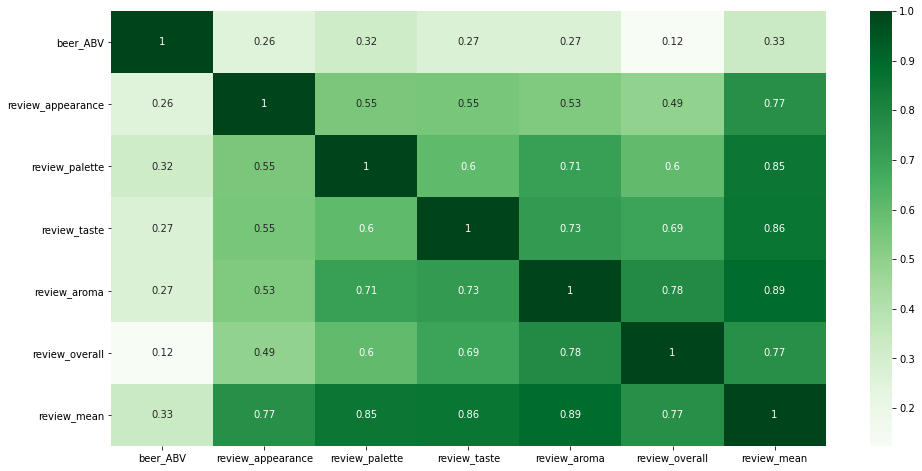

In [21]:
plt.figure(figsize=(16,8))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

### Scatter plot 

In [22]:
#Need to do this instead of df_agg.toPandas() beacuse on our pc it dosen't work
df_plot = df_agg.select('beer_ABV','review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'review_overall', 'review_mean').toPandas()

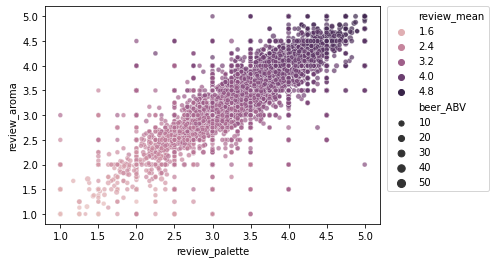

In [23]:
sns.scatterplot(data = df_plot, x="review_palette", y="review_aroma", hue="review_mean", size="beer_ABV", alpha=0.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

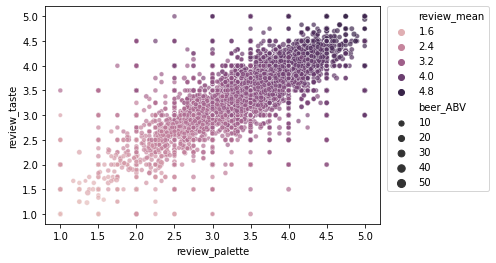

In [24]:
sns.scatterplot(data = df_plot, x="review_palette", y="review_taste", hue="review_mean", size="beer_ABV", alpha=0.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

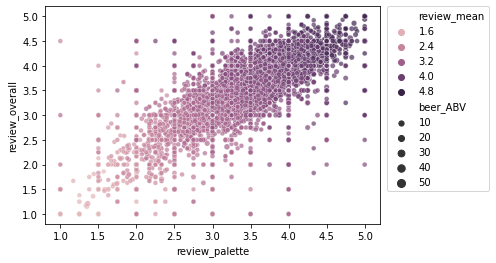

In [25]:
sns.scatterplot(data = df_plot, x="review_palette", y="review_overall", hue="review_mean", size="beer_ABV", alpha=0.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

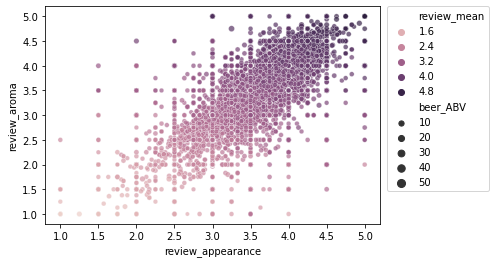

In [26]:
sns.scatterplot(data = df_plot, x="review_appearance", y="review_aroma", hue="review_mean", size="beer_ABV", alpha=0.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Data distribution

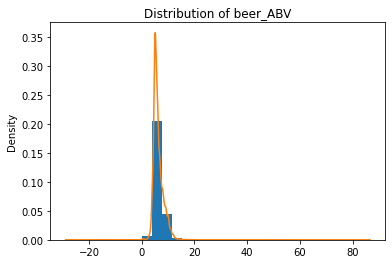

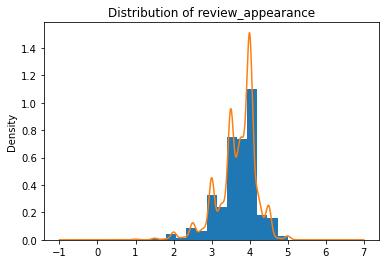

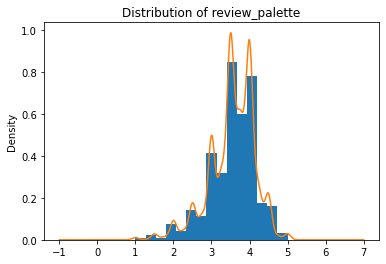

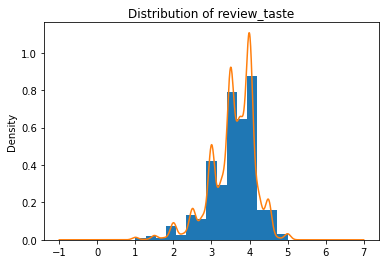

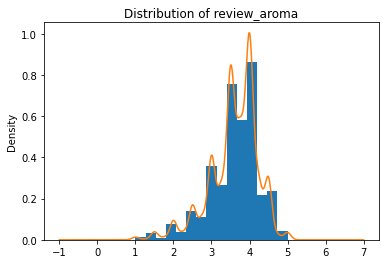

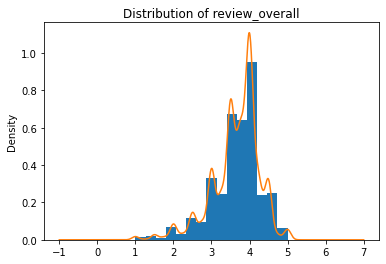

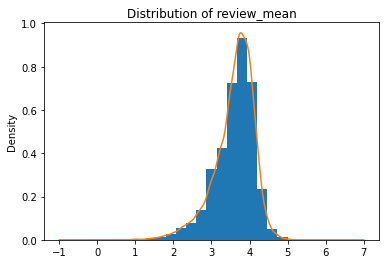

In [27]:
for c in df_plot.columns:
    plt.hist(df_plot[c], bins=15, density = True)
    df_plot[c].plot(kind='kde')
    plt.title("Distribution of " + c)
    plt.show()

# Clustering

## Preprocess the data

In [28]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [29]:
# Function that will be used to inverse the MinMax transformation of the centroid
def inverse_transform(scaler = None, centroids = None, df = None, columns = None):
    results = []
    _max = 1
    _min = 0
    for centeroid in centroids:
        cent = []
        for index, column in enumerate(columns):
            Xmax = df.select(column).agg(py_max(column)).collect()[0][0]
            Xmin = df.select(column).agg(py_min(column)).collect()[0][0]
            temp = (_max * Xmin - _min * Xmax - Xmin * centeroid[index] + Xmax * centeroid[index])/(_max - _min)
            cent.append(temp)
        results.append(cent)
    return results

In [30]:
cols = ['beer_ABV', 'review_appearance', 'review_palette', 'review_taste', 'review_aroma','review_overall','review_mean']

assembler = VectorAssembler(
    inputCols=cols,
    outputCol="features")

output_dataset = assembler.transform(df_agg)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

clusteringData = output_dataset.select("beer_name", "beer_style", "features_scaled")

clusteringData.show(5)

+--------------------+--------------------+--------------------+
|           beer_name|          beer_style|     features_scaled|
+--------------------+--------------------+--------------------+
|  Welsh Honey Bitter|      English Bitter|[0.07782977985786...|
|   Asmara Lager Beer|American Adjunct ...|[0.08649679320506...|
|Jennings Cumberla...|    English Pale Ale|[0.07262957184954...|
|Bring Me A Shrubb...|Scottish Gruit / ...|[0.09343040388282...|
|Hartmann Felsenke...|Keller Bier / Zwi...|[0.08649679320506...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



## K-Means

In [31]:
from pyspark.ml.clustering import KMeans

In [32]:
# Calculate k_means score for k from 2 to 20
score = []
for k in range(2,21):
    kmeans = KMeans(featuresCol="features_scaled").setK(k)
    model_k = kmeans.fit(clusteringData)
    predictions_kmeans = model_k.transform(clusteringData)
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    score.append(evaluator.evaluate(predictions_kmeans))
    print(k, end = " ")

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

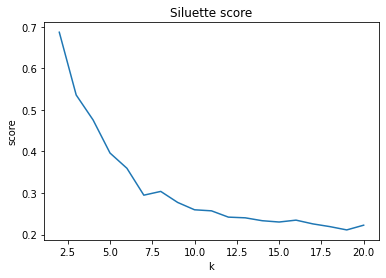

In [33]:
# plot the Siluette score 
plt.plot(range(2,21),score)
plt.title('Siluette score')
plt.xlabel('k')
plt.ylabel('score')
plt.show()

In [34]:
# K=2 
kmeans = KMeans(featuresCol="features_scaled").setK(2)
model_kmeans = kmeans.fit(clusteringData)

In [35]:
predictions_kmeans = model_kmeans.transform(clusteringData)
predictions_kmeans.show(5)

+--------------------+--------------------+--------------------+----------+
|           beer_name|          beer_style|     features_scaled|prediction|
+--------------------+--------------------+--------------------+----------+
|  Welsh Honey Bitter|      English Bitter|[0.07782977985786...|         0|
|   Asmara Lager Beer|American Adjunct ...|[0.08649679320506...|         0|
|Jennings Cumberla...|    English Pale Ale|[0.07262957184954...|         0|
|Bring Me A Shrubb...|Scottish Gruit / ...|[0.09343040388282...|         0|
|Hartmann Felsenke...|Keller Bier / Zwi...|[0.08649679320506...|         0|
+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [36]:
# Evaluate Kmeans clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions_kmeans)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.686785537833068


In [37]:
# Shows the result
centers_k = model_kmeans.clusterCenters()
print("Cluster Centers: ")
for center in centers_k:
    print(center)

Cluster Centers: 
[0.11314311 0.71832862 0.70191471 0.70795765 0.72271909 0.73284067
 0.71298171]
[0.09519875 0.54241153 0.46576588 0.46982356 0.45299267 0.47515103
 0.48304936]


In [38]:
centroids_k = inverse_transform(scaler = scaler, centroids = centers_k, df = df_agg, columns = cols)

In [39]:
for centroid in centroids_k:
    print(centroid)

[6.537226180856795, 3.87331447880702, 3.8076588555057604, 3.8318306030999736, 3.8908763681774765, 3.9313626680378992, 3.851926834643324]
[5.502015640273662, 3.169646138807424, 2.8630635386119265, 2.879294232649069, 2.8119706744868, 2.9006041055718486, 2.9321974584555126]


Index to access column values of the centroid \
0: beer_ABV \
1: review_appearance \
2: review_palette \
3: review_taste \
4: review_aroma \
5: review_overall \
6: review_mean 

### Visualize K-Means cluster 

In [42]:
#Remove unnecessary columns
columns_to_drop = ['beer_style', 'features_scaled']
temp = predictions_kmeans.drop(*columns_to_drop)
temp = temp.withColumnRenamed("beer_name","beer_name_temp")

#Merge the prediction column in the original dataframe (df_agg)
df_km = df_agg.join(temp, df_agg.beer_name == temp.beer_name_temp,"inner")
df_km = df_km.drop('beer_name_temp')

#Convert the dataframe (only some columns) to a panda dataframe for plotting purposes
df_k = df_km.select('beer_ABV', 'review_taste', 'review_aroma', 'prediction', 'review_overall', 'review_appearance').toPandas()

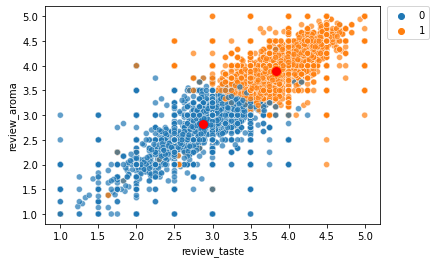

In [77]:
# scatter plot for review_taste and review_aroma
sns.scatterplot(data=df_k, x='review_taste', y='review_aroma', hue="prediction", alpha=0.7)
plt.plot(centroids_k[0][3], centroids_k[0][4], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_k[1][3], centroids_k[1][4], marker="o", markersize=10, markerfacecolor="red")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

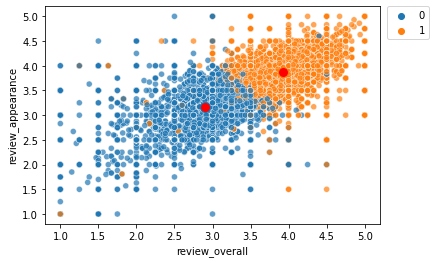

In [78]:
# scatter plot for review_overall and review_appearance
sns.scatterplot(data=df_k, x='review_overall', y='review_appearance', hue="prediction", alpha=0.7)
plt.plot(centroids_k[0][5], centroids_k[0][1], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_k[1][5], centroids_k[1][1], marker="o", markersize=10, markerfacecolor="red")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

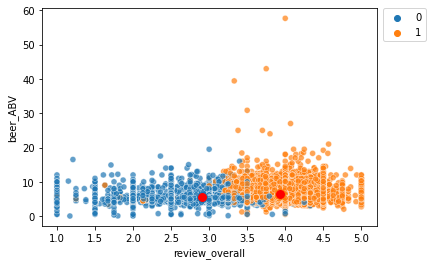

In [79]:
# scatter plot for review_overall and beer_ABV
sns.scatterplot(data=df_k, x='review_overall', y='beer_ABV', hue="prediction", alpha=0.7)
plt.plot(centroids_k[0][5], centroids_k[0][0], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_k[1][5], centroids_k[1][0], marker="o", markersize=10, markerfacecolor="red")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Analyze cluster elements

In [44]:
# Count element in each cluster grouped by beer_style 
predictions_kmeans.createOrReplaceTempView("schema_kmeans")

query = """SELECT beer_style,
            COUNT(CASE prediction WHEN 0 then 1 else null END) as Zero,
            COUNT(CASE prediction WHEN 1 then 1 else null END) as One
            FROM schema_kmeans 
            GROUP BY beer_style"""

results = sqlCtx.sql(query)
results.show(10)

+--------------------+----+---+
|          beer_style|Zero|One|
+--------------------+----+---+
|       Baltic Porter|  88| 12|
|  Milk / Sweet Stout| 105| 20|
|American Dark Whe...|  23|  7|
|American Amber / ...|  53| 66|
|              Dubbel| 135| 21|
|Dortmunder / Expo...|  49| 41|
|              Tripel| 217| 32|
|Belgian Strong Da...| 194| 36|
|Belgian Strong Pa...| 248| 46|
|           Wheatwine|  30|  3|
+--------------------+----+---+
only showing top 10 rows



In [45]:
for i in cols:
    print(i)
    df_km.groupby('prediction').agg(avg(i).alias('Mean cluster')).show()

beer_ABV
+----------+-----------------+
|prediction|     Mean cluster|
+----------+-----------------+
|         1|5.493069597069607|
|         0|6.509032818801233|
+----------+-----------------+

review_appearance
+----------+------------------+
|prediction|      Mean cluster|
+----------+------------------+
|         1|3.1885311355311257|
|         0|3.8632241691002216|
+----------+------------------+

review_palette
+----------+------------------+
|prediction|      Mean cluster|
+----------+------------------+
|         1|2.8941043956043804|
|         0| 3.793710193297137|
+----------+------------------+

review_taste
+----------+------------------+
|prediction|      Mean cluster|
+----------+------------------+
|         1|2.9117490842490747|
|         0|  3.81653594771238|
+----------+------------------+

review_aroma
+----------+------------------+
|prediction|      Mean cluster|
+----------+------------------+
|         1|2.8484652014651903|
|         0| 3.874343623974381|
+-----

## Bisecting K-Means

In [213]:
from pyspark.ml.clustering import BisectingKMeans

In [214]:
score = []
for k in range(2,15):
    bkm = BisectingKMeans(featuresCol='features_scaled',k=k, minDivisibleClusterSize=1.0)
    model_bisect = bkm.fit(clusteringData)
    predictions_bisecting = model_bisect.transform(clusteringData)
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    score.append(evaluator.evaluate(predictions_bisecting))
    print(k, end = " ")

2 3 4 5 6 7 8 9 10 11 12 13 14 

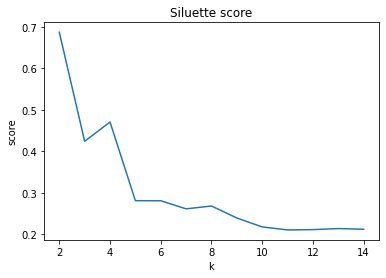

In [215]:
plt.plot(range(2,15),score)
plt.title('Siluette score')
plt.xlabel('k')
plt.ylabel('score')
plt.show()

In [216]:
bkm = BisectingKMeans(featuresCol='features_scaled',k=4, minDivisibleClusterSize=1.0)
model_bisect = bkm.fit(clusteringData)

In [217]:
predictions_bisecting = model_bisect.transform(clusteringData)
predictions_bisecting.show(5)

+--------------------+--------------------+--------------------+----------+
|           beer_name|          beer_style|     features_scaled|prediction|
+--------------------+--------------------+--------------------+----------+
|  Welsh Honey Bitter|      English Bitter|[0.07782977985786...|         2|
|   Asmara Lager Beer|American Adjunct ...|[0.08649679320506...|         2|
|Jennings Cumberla...|    English Pale Ale|[0.07262957184954...|         2|
|Bring Me A Shrubb...|Scottish Gruit / ...|[0.09343040388282...|         2|
|Hartmann Felsenke...|Keller Bier / Zwi...|[0.08649679320506...|         3|
+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [218]:
# Evaluate Bisecting Kmeans clustering by computing Silhouette score
evaluator_bisecting = ClusteringEvaluator(featuresCol="features_scaled")
silhouette_bisecting = evaluator_bisecting.evaluate(predictions_bisecting)
print("Silhouette with squared euclidean distance = " + str(silhouette_bisecting))

Silhouette with squared euclidean distance = 0.4704485202482264


In [219]:
# Shows the result.
centers_bi = model_bisect.clusterCenters()
print("Cluster Centers: ")
for center in centers_bi:
    print(center)

Cluster Centers: 
[0.09063985 0.42766453 0.31624197 0.27287721 0.29540128 0.30831461
 0.33162119]
[0.09666693 0.57936547 0.51928405 0.51099832 0.5330389  0.5164726
 0.53181636]
[0.10668314 0.68216993 0.65656769 0.66420829 0.68134842 0.64811897
 0.66298574]
[0.1209939  0.76227217 0.77041172 0.7938271  0.79541904 0.76729251
 0.77374166]


In [220]:
centroids_bi = inverse_transform(scaler = scaler, centroids = centers_bi, df = df_agg, columns = cols)

In [221]:
for centroid in centroids_bi:
    print(centroid)

[5.239012841091498, 2.710658105939006, 2.2649678972712683, 2.0915088282504026, 2.1816051364365965, 2.2332584269662936, 2.3264847512038624]
[5.586714913414298, 3.317461876453866, 3.0771362109072165, 3.043993279917295, 3.1321555957611826, 3.065890410958909, 3.1272654432670155]
[6.16455008034258, 3.7286797000535588, 3.6262707552222726, 3.6568331547937776, 3.725393679700051, 3.592475897161209, 3.651942956614875]
[6.9901383238404176, 4.049088689991855, 4.081646867371841, 4.175308380797392, 4.181676159479247, 4.0691700569568745, 4.0949666395443085]


### Visualize Bisecting K-Means clusters

In [57]:
columns_to_drop = ['beer_style', 'features_scaled']
temp = predictions_bisecting.drop(*columns_to_drop)
temp = temp.withColumnRenamed("beer_name","beer_name_temp")

df_b = df_agg.join(temp, df_agg.beer_name == temp.beer_name_temp,"inner")
df_b = df_b.drop('beer_name_temp')

df_bis = df_b.select('beer_ABV', 'review_taste', 'review_aroma', 'prediction', 'review_overall', 'review_appearance','review_palette').toPandas()

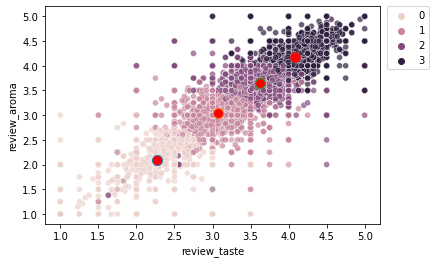

In [58]:
sns.scatterplot(data=df_bis, x='review_taste', y='review_aroma', hue="prediction", alpha=0.7)
plt.plot(centroids_bi[0][3], centroids_bi[0][4], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_bi[1][3], centroids_bi[1][4], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_bi[2][3], centroids_bi[2][4], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_bi[3][3], centroids_bi[3][4], marker="o", markersize=10, markerfacecolor="red")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

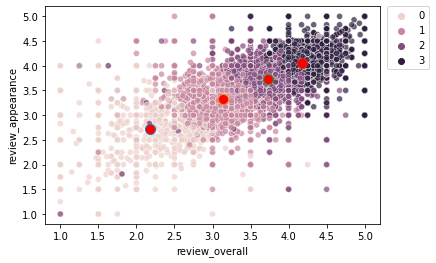

In [59]:
sns.scatterplot(data=df_bis, x='review_overall', y='review_appearance', hue="prediction", alpha=0.7)
plt.plot(centroids_bi[0][5], centroids_bi[0][1], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_bi[1][5], centroids_bi[1][1], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_bi[2][5], centroids_bi[2][1], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_bi[3][5], centroids_bi[3][1], marker="o", markersize=10, markerfacecolor="red")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

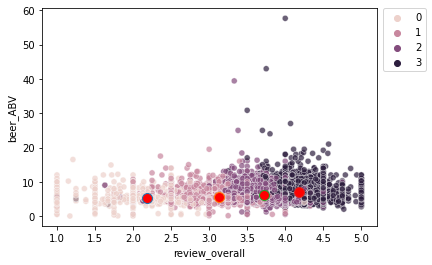

In [60]:
sns.scatterplot(data=df_bis, x='review_overall', y='beer_ABV', hue="prediction", alpha=0.7)
plt.plot(centroids_bi[0][5], centroids_bi[0][0], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_bi[1][5], centroids_bi[1][0], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_bi[2][5], centroids_bi[2][0], marker="o", markersize=10, markerfacecolor="red")
plt.plot(centroids_bi[3][5], centroids_bi[3][0], marker="o", markersize=10, markerfacecolor="red")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Analyze cluster elements

In [226]:
predictions_bisecting.createOrReplaceTempView("beer_schema")

query = """SELECT beer_style,
            COUNT(CASE prediction WHEN 0 then 1 else null END) as Zero,
            COUNT(CASE prediction WHEN 1 then 1 else null END) as One,
            COUNT(CASE prediction WHEN 2 then 1 else null END) as Two,
            COUNT(CASE prediction WHEN 3 then 1 else null END) as Three
            FROM beer_schema 
            GROUP BY beer_style"""
results = sqlCtx.sql(query)
results.show(10)

+--------------------+----+---+---+-----+
|          beer_style|Zero|One|Two|Three|
+--------------------+----+---+---+-----+
|       Baltic Porter|   2| 10| 32|   56|
|  Milk / Sweet Stout|   5| 15| 47|   58|
|American Dark Whe...|   2|  5| 15|    8|
|American Amber / ...|  17| 49| 40|   13|
|              Dubbel|   4| 17| 75|   60|
|Dortmunder / Expo...|  11| 30| 28|   21|
|              Tripel|   4| 28|122|   95|
|Belgian Strong Da...|   5| 31|105|   89|
|Belgian Strong Pa...|   9| 37|124|  124|
|           Wheatwine|   0|  3| 11|   19|
+--------------------+----+---+---+-----+
only showing top 10 rows



In [48]:
for i in cols:
    print(i)
    df_b.groupby('prediction').agg(avg(i).alias('Mean cluster')).show()

beer_ABV
+----------+-----------------+
|prediction|     Mean cluster|
+----------+-----------------+
|         1|5.573957477651627|
|         3|6.957799812617074|
|         2|6.148804211581811|
|         0|5.239629068887209|
+----------+-----------------+

review_appearance
+----------+------------------+
|prediction|      Mean cluster|
+----------+------------------+
|         1| 3.326721430297165|
|         3|4.0362023735165495|
|         2|3.7243732765104065|
|         0|  2.75554882664648|
+----------+------------------+

review_palette
+----------+------------------+
|prediction|      Mean cluster|
+----------+------------------+
|         1|3.0852210678907843|
|         3|4.0501514678326105|
|         2|3.5878628729004873|
|         0| 2.295291445874341|
+----------+------------------+

review_taste
+----------+------------------+
|prediction|      Mean cluster|
+----------+------------------+
|         1| 3.097919787388253|
|         3| 4.062129918800747|
|         2|3.61939583

# Classification

In [61]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Preprocessing

In [62]:
from pyspark.ml.feature import Binarizer

For the classification task we create two target variable: 
1) review_bin: for binary classification and is obtained binarizing review_overall 
2) review_target: for multiclass classification and is obtained rounding review_overall

As threshold we used 2.5, so if the value of review_overall was less than 2.5 the output is 0, while it is 1 if greater than or equal.

In [63]:
#binarize
binarizer = Binarizer(threshold=2.5, inputCol="review_overall", outputCol="review_bin")
df_class = binarizer.transform(df_agg)

In [64]:
#round
df_class = df_class.withColumn("review_target", py_round("review_overall"))

In [65]:
cols = ['beer_ABV', 'review_appearance', 'review_palette', 'review_taste', 'review_aroma']

assembler = VectorAssembler(
    inputCols=cols,
    outputCol="features")

output_dataset = assembler.transform(df_class)

df_class = output_dataset.select("beer_name", "features", "review_bin", "review_target")

df_class.show(5)

+--------------------+--------------------+----------+-------------+
|           beer_name|            features|review_bin|review_target|
+--------------------+--------------------+----------+-------------+
|  Welsh Honey Bitter|[4.5,3.0,3.75,3.5...|       1.0|          3.0|
|   Asmara Lager Beer|[5.0,3.5,3.5,3.0,...|       1.0|          4.0|
|Jennings Cumberla...|[4.2,3.64,3.43,3....|       1.0|          4.0|
|Bring Me A Shrubb...|[5.4,4.0,3.0,3.5,...|       1.0|          4.0|
|Hartmann Felsenke...|[5.0,3.83,3.83,3....|       1.0|          4.0|
+--------------------+--------------------+----------+-------------+
only showing top 5 rows



In [68]:
(train, test) = df_class.randomSplit([0.7, 0.3],seed=42)

## Multiclass Classification

'review_target' as target variable

### Random forest

In [69]:
from pyspark.ml.classification import RandomForestClassifier

We did a grid search to tune the model, testing the performance of each combination of parameters with the TrainValidationSplit

In [70]:
rf = RandomForestClassifier(labelCol="review_target", featuresCol="features")

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [5, 10, 15]) \
    .addGrid(rf.maxDepth, [5, 10])\
    .addGrid(rf.impurity, ['gini','entropy'])\
    .build()

tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol="review_target", predictionCol="prediction", metricName="accuracy"),
                           trainRatio=0.8) # 80% of the data will be used for training, 20% for validation.

random_forest = tvs.fit(train)

The TrainValidationSplit selects the model with the best combination of parameters to use with the Test data. In this case the choice was made based on the accuracy of each model

In [71]:
predictions = random_forest.transform(test).select("features", "review_target", "prediction")
predictions.show(5)

+--------------------+-------------+----------+
|            features|review_target|prediction|
+--------------------+-------------+----------+
|[7.6,3.5,4.0,4.0,...|          4.0|       4.0|
|[5.0,3.17,2.58,3....|          3.0|       3.0|
|[5.4,3.5,4.0,3.5,...|          4.0|       3.0|
|[7.2,4.0,4.0,4.0,...|          4.0|       4.0|
|[6.7,4.0,4.0,4.0,...|          4.0|       3.0|
+--------------------+-------------+----------+
only showing top 5 rows



In [72]:
evaluator = MulticlassClassificationEvaluator(labelCol="review_target", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

print("The accuracy of the model is: {}".format(round(accuracy, 2)))
print("Test Error = {}".format(round((1.0 - accuracy), 2)))

The accuracy of the model is: 0.82
Test Error = 0.18


In [74]:
eval_f1 = MulticlassClassificationEvaluator(labelCol='review_target',
                                            predictionCol='prediction',
                                            metricName='f1')
f1_score = eval_f1.evaluate(predictions)

print("The f1 score of the model is: {}".format(round(f1_score, 2)))

The f1 score of the model is: 0.8


In [75]:
nt = random_forest.bestModel.getOrDefault("numTrees")
md = random_forest.bestModel.getOrDefault("maxDepth")
im = random_forest.bestModel.getOrDefault("impurity")

print('''The best model has the following pratameters:
- numbers of tree: {}
- max depth: {}
- impurity mesaure: {}'''.format(nt, md, im))

The best model has the following pratameters:
- numbers of tree: 10
- max depth: 5
- impurity mesaure: entropy


### Logistic Regression

In [76]:
from pyspark.ml.classification import LogisticRegression

In [77]:
lr = LogisticRegression(labelCol="review_target", featuresCol="features")

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.05, 0.1, 0.2, 0.5]) \
    .addGrid(lr.threshold, [0.3, 0.5, 0.7])\
    .addGrid(lr.maxIter, [50, 100])\
    .build()

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol="review_target", predictionCol="prediction", metricName="accuracy"),
                           trainRatio=0.8) # 80% of the data will be used for training, 20% for validation.

logistic = tvs.fit(train)

In [78]:
predictions = logistic.transform(test).select("features", "review_target", "prediction")
predictions.show(5)

+--------------------+-------------+----------+
|            features|review_target|prediction|
+--------------------+-------------+----------+
|[7.6,3.5,4.0,4.0,...|          4.0|       4.0|
|[5.0,3.17,2.58,3....|          3.0|       3.0|
|[5.4,3.5,4.0,3.5,...|          4.0|       3.0|
|[7.2,4.0,4.0,4.0,...|          4.0|       4.0|
|[6.7,4.0,4.0,4.0,...|          4.0|       4.0|
+--------------------+-------------+----------+
only showing top 5 rows



In [79]:
evaluator = MulticlassClassificationEvaluator(labelCol="review_target", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

print("The accuracy of the model is: {}".format(round(accuracy, 2)))
print("Test Error = {}".format(round((1.0 - accuracy), 2)))

The accuracy of the model is: 0.82
Test Error = 0.18


In [80]:
eval_f1 = MulticlassClassificationEvaluator(labelCol='review_target',
                                            predictionCol='prediction',
                                            metricName='f1')
f1_score = eval_f1.evaluate(predictions)

print("The f1 score of the model is: {}".format(round(f1_score, 2)))

The f1 score of the model is: 0.8


In [81]:
rp = logistic.bestModel.getOrDefault("regParam")
th = logistic.bestModel.getOrDefault("threshold")
mi = logistic.bestModel.getOrDefault("maxIter")

print('''The best model has the following pratameters:
- regression parameter: {}
- threshold: {}
- max iterarion: {}'''.format(rp, th, mi))

The best model has the following pratameters:
- regression parameter: 0.0
- threshold: 0.3
- max iterarion: 100


## Binary Classification

"review_bin" as target variable

### Gradient Boosting Tree

In [69]:
from pyspark.ml.classification import GBTClassifier

For the Gradient Boosting Tree we didn't use the ParamGridBuilder and TrainValidationSplit to do the GridSearch because it was too slow. We performed the tuning of the parameters through two for loops.

In [70]:
#We keep the same ratio train - validation of the TrainValidationSplit
(train_gb, val_gb) = train.randomSplit([0.8, 0.2],seed=42)

In [71]:
#the parameters we want to test
depth = [5, 10]
min_ins = [1, 2, 5, 10]

#Variables to store the best model and its parameters
best_model = None
best_auc = 0
best_d = None
best_ins = None

for d in depth: #iterate over the maxDepth 
    for ins in min_ins: #iterate over the minInstancesPerNode
        
        gb = GBTClassifier(labelCol="review_bin", featuresCol="features", minInstancesPerNode = ins, maxDepth = d)
        gradient = gb.fit(train_gb)
        
        predictions = gradient.transform(val_gb).select("features", "review_bin", "rawPrediction")
        
        evaluator_bin = BinaryClassificationEvaluator(labelCol="review_bin", 
                                              rawPredictionCol="rawPrediction", 
                                              metricName="areaUnderROC")

        auc = evaluator_bin.evaluate(predictions)
        
        if auc > best_auc: #if the Area Under the Curve is greater of the previous best model the actual model is the new best
            best_auc = auc
            best_model = gradient.copy() #store a copy of the model, so it can be used with the Test data
            best_d = d
            best_ins = ins

In [72]:
predictions = best_model.transform(test).select("features", "review_bin", "prediction", "rawPrediction")
predictions.show(5)

+--------------------+----------+----------+--------------------+
|            features|review_bin|prediction|       rawPrediction|
+--------------------+----------+----------+--------------------+
|[7.6,3.5,4.0,4.0,...|       1.0|       1.0|[-1.5397029105565...|
|[5.0,3.17,2.58,3....|       1.0|       1.0|[-0.3614872144558...|
|[5.4,3.5,4.0,3.5,...|       1.0|       1.0|[-1.4072671949278...|
|[7.2,4.0,4.0,4.0,...|       1.0|       1.0|[-1.5407810283491...|
|[6.7,4.0,4.0,4.0,...|       1.0|       1.0|[-1.3308979283516...|
+--------------------+----------+----------+--------------------+
only showing top 5 rows



We did two evaluation, one the binary evaluator that use the area under the curve as metric (because it doesn't support accuracy), and the multiclass evaluator with accuracy to confront the result with the ones of the other classifiers 

In [73]:
evaluator_bin = BinaryClassificationEvaluator(labelCol="review_bin", 
                                              rawPredictionCol="rawPrediction", 
                                              metricName="areaUnderROC")

auc = evaluator_bin.evaluate(predictions)

print("The area under the curve of the model is: {}".format(round(auc, 2)))

The area under the curve of the model is: 0.98


In [74]:
evaluator = MulticlassClassificationEvaluator(labelCol="review_bin", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

print("The accuracy of the model is: {}".format(round(accuracy, 2)))
print("Test Error = {}".format(round((1.0 - accuracy), 2)))

The accuracy of the model is: 0.97
Test Error = 0.03


In [75]:
eval_f1 = MulticlassClassificationEvaluator(labelCol='review_bin',
                                            predictionCol='prediction',
                                            metricName='f1')
f1_score = eval_f1.evaluate(predictions)

print("The f1 score of the model is: {}".format(round(f1_score, 2)))

The f1 score of the model is: 0.97


In [76]:
print('''The best model has the following pratameters:
- min instances per node: {}
- max depth: {}'''.format(best_ins, best_d))

The best model has the following pratameters:
- min instances per node: 5
- max depth: 5


### Naive bayes

In [90]:
from pyspark.ml.classification import NaiveBayes

In [91]:
nb = NaiveBayes(labelCol="review_bin", featuresCol="features")

paramGrid = ParamGridBuilder()\
    .addGrid(nb.modelType, ["multinomial", "gaussian"]) \
    .addGrid(nb.smoothing, [1.0, 1.5, 2.0, 3.0, 5.0])\
    .build()

tvs = TrainValidationSplit(estimator=nb,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(labelCol="review_bin", rawPredictionCol="rawPrediction", metricName="areaUnderROC"),
                           trainRatio=0.8) # 80% of the data will be used for training, 20% for validation.

naive = tvs.fit(train)

In [92]:
predictions = naive.transform(test).select("features", "review_bin", "prediction", "rawPrediction")
predictions.show(5)

+--------------------+----------+----------+--------------------+
|            features|review_bin|prediction|       rawPrediction|
+--------------------+----------+----------+--------------------+
|[7.6,3.5,4.0,4.0,...|       1.0|       1.0|[-17.769065088087...|
|[5.0,3.17,2.58,3....|       1.0|       0.0|[-1.8858128389683...|
|[5.4,3.5,4.0,3.5,...|       1.0|       1.0|[-7.1688127523953...|
|[7.2,4.0,4.0,4.0,...|       1.0|       1.0|[-14.922422217478...|
|[6.7,4.0,4.0,4.0,...|       1.0|       1.0|[-10.195000538553...|
+--------------------+----------+----------+--------------------+
only showing top 5 rows



In [93]:
evaluator_bin = BinaryClassificationEvaluator(labelCol="review_bin", 
                                              rawPredictionCol="rawPrediction", 
                                              metricName="areaUnderROC")

auc = evaluator_bin.evaluate(predictions)

print("The area under the curve of the model is: {}".format(round(auc, 2)))

The area under the curve of the model is: 0.96


In [94]:
evaluator = MulticlassClassificationEvaluator(labelCol="review_bin", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

print("The accuracy of the model is: {}".format(round(accuracy, 2)))
print("Test Error = {}".format(round((1.0 - accuracy), 2)))

The accuracy of the model is: 0.94
Test Error = 0.06


In [95]:
eval_f1 = MulticlassClassificationEvaluator(labelCol='review_bin',
                                            predictionCol='prediction',
                                            metricName='f1')
f1_score = eval_f1.evaluate(predictions)

print("The f1 score of the model is: {}".format(round(f1_score, 2)))

The f1 score of the model is: 0.95


In [96]:
mt = naive.bestModel.getOrDefault("modelType")
sm = naive.bestModel.getOrDefault("smoothing")

print('''The best model has the following pratameters:
- model: {}
- smoothing: {}'''.format(mt, sm))

The best model has the following pratameters:
- model: gaussian
- smoothing: 1.0


# NLP 

In [17]:
import sparknlp
import findspark
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline, PipelineModel 
from pyspark.ml.feature import CountVectorizer, StringIndexer, RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import udf, regexp_replace, isnull, when, lit
from pyspark.sql.types import StringType, IntegerType

findspark.init()

spark_npl = sparknlp.start()
spark_npl.version
sparknlp.version()

'4.2.4'

In [19]:
df = df.withColumn("sentiment", when((df.review_overall < 4), lit("negative")).otherwise(lit("positive")))

In [20]:
df.show(5)

+--------+-----------+-------------+--------------------+--------------------+-----------------+--------------+------------+------------+--------------+--------------------+-----------+---------+
|beer_ABV|beer_beerId|beer_brewerId|           beer_name|          beer_style|review_appearance|review_palette|review_taste|review_aroma|review_overall|         review_text|review_mean|sentiment|
+--------+-----------+-------------+--------------------+--------------------+-----------------+--------------+------------+------------+--------------+--------------------+-----------+---------+
|     6.5|      48215|        10325|Black Horse Black...|Foreign / Export ...|              3.0|           2.5|         3.0|         3.0|           3.0|Almost totally bl...|      2.875| negative|
|     4.7|      52159|         1075| Caldera Ginger Beer|Herbed / Spiced Beer|              3.5|           3.5|         3.0|         3.5|           3.0|Poured from the b...|      3.375| negative|
|     6.2|      4821

In [21]:
df_count = df.select("sentiment")
df_count.groupBy("sentiment").count().show()

+---------+------+
|sentiment| count|
+---------+------+
| positive|338410|
| negative|190341|
+---------+------+



In [22]:
df_nlp = df.select("review_text")
df_nlp.show(5)

+--------------------+
|         review_text|
+--------------------+
|Almost totally bl...|
|Poured from the b...|
|Dark red color, l...|
|According to the ...|
|Golden yellow col...|
+--------------------+
only showing top 5 rows



DocumentAssembler() prepares data into a format that is processable by Spark NLP. This is the entry point for every Spark NLP pipeline. The DocumentAssembler can read either a String column or an Array.

In [23]:
document = DocumentAssembler().setInputCol("review_text").setOutputCol("document")

Tokenizer() tokenizes raw text in document type columns into TokenizedSentence.

In [24]:
token = Tokenizer().setInputCols(["document"]).setOutputCol("token")

Normalizer() is an annotator that cleans out tokens. Requires stems, hence tokens. Removes all dirty characters from text following a regex pattern and transforms words based on a provided dictionary

In [25]:
normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normal")

ViveknSentimentModel is a Naive Bayes classifier for sentiment analysis

In [26]:
vivekn =  ViveknSentimentModel.pretrained().setInputCols(["document", "normal"]).setOutputCol("result_sentiment")

sentiment_vivekn download started this may take some time.
Approximate size to download 873,6 KB
[OK!]


Finisher() converts annotation results into a format that easier to use. It is useful to extract the results from Spark NLP Pipelines. The Finisher outputs annotation(s) values into String.

In [27]:
finisher = Finisher().setInputCols(["result_sentiment"]).setOutputCols("final_sentiment")

In [28]:
pipeline = Pipeline().setStages([document, token, normalizer, vivekn, finisher])

In [29]:
data = df_nlp.toDF("review_text")
pipelineModel = pipeline.fit(data)
result = pipelineModel.transform(data)
result.show()

+--------------------+---------------+
|         review_text|final_sentiment|
+--------------------+---------------+
|Labelled as Cwrw ...|     [negative]|
|"A: Golden-yellow...|     [negative]|
|This is a common ...|     [positive]|
|Bottle @ sandwich...|     [negative]|
|Pours a golden am...|     [negative]|
|500 mL brown bott...|     [negative]|
|A 500ml green gla...|     [negative]|
|Drank from my Bom...|     [negative]|
|Bottle straight f...|     [negative]|
|Green bottle unli...|     [negative]|
|Beer bottle (50 c...|     [negative]|
|500ml bottle 4.2 ...|     [positive]|
|Another top pint ...|     [positive]|
|50cl bottle, as s...|     [negative]|
|Hm, my bottel had...|     [negative]|
|Very suprised to ...|     [negative]|
|(From notes) A - ...|     [negative]|
|Found this in a b...|     [negative]|
|"500ml brown bott...|     [negative]|
|Appearance- Coppe...|     [negative]|
+--------------------+---------------+
only showing top 20 rows



In [30]:
result.groupby(["final_sentiment"]).count().show()

+---------------+------+
|final_sentiment| count|
+---------------+------+
|     [positive]|211896|
|     [negative]|316688|
|           [na]|   167|
+---------------+------+

